#### Imports

In [1]:
%matplotlib inline

In [2]:
# Install a pip package in the current Jupyter kernel
import sys

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors

from IPython.core.display import display, HTML

In [4]:
warnings.filterwarnings('ignore')

In [5]:

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "12pt")]),
            dict(selector="td",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

def display_dataframe(df):
    return df.style.hide_index().set_table_styles(magnify()).set_precision(2)

In [6]:
sns.set()
size=22
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}

plt.rcParams.update(params)

In [7]:
display(HTML("<style>.container { width:90% !important; }</style>"))

HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:left;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
}
</style>
""")

## Advanced feature engineering techniques
1. Brief introduction
1. Mean encodings
    * the basic concept
    * simple implementation with some scores
    * what are the issues with the naive approach
1. Regularization of mean encodings
    * cross validation approach
    * smoothing of the encodings
1. Extensions ot the method
1. Group statistics
1. Group statistics with nearest neighbour
1. Feature interactions and selection
1. Sparse feature selection

### 1. Brief introduction

What are we trying to solve here?

Very brief recap of decision trees, random forest and gradient boosting.

Libraries to try out:

* **xgboost** extreme gradient boosting [link](https://xgboost.readthedocs.io/en/latest/)
* **lightgbm** more recent [link](https://lightgbm.readthedocs.io/en/latest/)
* **catboost** newest, really good with categorical features [link](https://catboost.ai/)

### 2. Category encodings and introduction to mean encodings

Other names of mean encodings, are target encodings and likelihood encodings.

#### Data loading

In [34]:
data = pd.read_csv('cat-in-the-dat/train.csv', nrows=50_000)
train, test, _, _ = train_test_split(data, data['target'], random_state=1)
train, test = train.copy(), test.copy()

In [35]:
display_dataframe(data.head())

id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [36]:
categorical = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
target = 'target'

In [37]:
display_dataframe(train[categorical + [target]].head())

nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,target
Red,Triangle,Cat,Costa Rica,Bassoon,586b51342,a19d81efe,880957c19,d69adef8b,7fe5ee983,1
Red,Square,Snake,Finland,Bassoon,19db35594,6ea52a806,4a0ff1117,178ac6030,35a9ee7ef,0
Red,Trapezoid,Lion,China,Theremin,0b3bec656,e866d44ea,b8240e94d,fe593b910,6fda251fa,0
Blue,Square,Lion,Finland,Oboe,af088d192,55a24a71b,f1aec6b64,802d6605a,7747eac5f,0
Green,Star,Cat,Russia,Piano,c0534106d,12d88c9c3,f16ff4894,66c666931,64f44d6dd,0


In [12]:
display_dataframe(train[categorical].nunique().\
                  reset_index().\
                  rename({'index': 'feature', 0:'n_unique'}, axis=1))

feature,n_unique
nom_0,3
nom_1,6
nom_2,6
nom_3,6
nom_4,4
nom_5,222
nom_6,519
nom_7,1206
nom_8,2172
nom_9,10223


#### Standard label encoding

In [13]:
feature_name = 'nom_2'

In [14]:
data[feature_name].unique()

array(['Snake', 'Hamster', 'Lion', 'Cat', 'Dog', 'Axolotl'], dtype=object)

Axolotl: https://en.wikipedia.org/wiki/Axolotl - walking fish :)

In [38]:
def label_encode(feature_name, train, test):
    vals = train[feature_name].unique()
    mapping = {v: i for i, v in enumerate(vals)}

    train[f'{feature_name}_enc'] = train[feature_name].apply(lambda v : mapping.get(v, -1))
    test[f'{feature_name}_enc'] = test[feature_name].apply(lambda v : mapping.get(v, -1))
    
encoded_categorical = [f'{feature_name}_enc' for feature_name in categorical]

In [31]:
label_encode(feature_name, train, test)
display_dataframe(train[[f'{feature_name}', f'{feature_name}_enc']].head(10))

nom_2,nom_2_enc
Cat,0
Snake,1
Lion,2
Lion,2
Cat,0
Axolotl,3
Snake,1
Axolotl,3
Dog,4
Snake,1


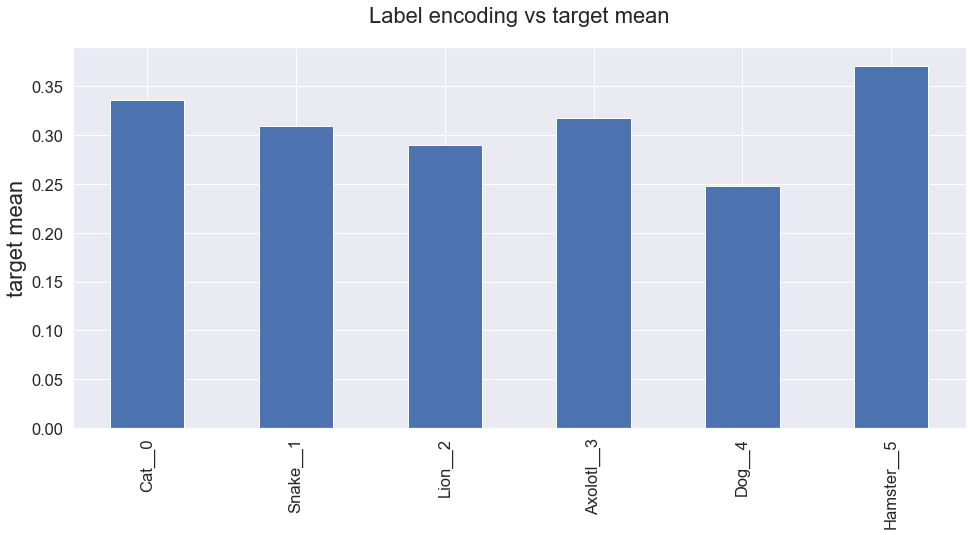

In [32]:
encoded_cats = train.groupby(feature_name)[f'{feature_name}_enc'].first().to_dict()
encoded_cats = {v:f'{k}__{v:d}' for k,v in encoded_cats.items()}

grp = train.groupby(f'{feature_name}_enc')[target].mean()
grp.index = [encoded_cats[idx] for idx in grp.index]
grp.plot(kind='bar', figsize=(16, 7))
plt.title('Label encoding vs target mean')
plt.ylabel('target mean');

In [39]:
display_dataframe(train.head())

id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
25772,0,0,0,T,N,Red,Triangle,Cat,Costa Rica,Bassoon,586b51342,a19d81efe,880957c19,d69adef8b,7fe5ee983,1,Grandmaster,Cold,i,Q,ps,2,2,1
45791,1,0,0,T,Y,Red,Square,Snake,Finland,Bassoon,19db35594,6ea52a806,4a0ff1117,178ac6030,35a9ee7ef,1,Grandmaster,Hot,l,R,uy,7,3,0
25396,0,0,1,F,N,Red,Trapezoid,Lion,China,Theremin,0b3bec656,e866d44ea,b8240e94d,fe593b910,6fda251fa,1,Novice,Lava Hot,c,B,XI,7,1,0
43835,0,1,0,F,Y,Blue,Square,Lion,Finland,Oboe,af088d192,55a24a71b,f1aec6b64,802d6605a,7747eac5f,1,Grandmaster,Lava Hot,j,Q,sY,1,11,0
15782,0,0,1,F,N,Green,Star,Cat,Russia,Piano,c0534106d,12d88c9c3,f16ff4894,66c666931,64f44d6dd,2,Contributor,Freezing,g,Z,kr,3,11,0


In [40]:
def train_xgb_model(train, test):
    dm_train = xgb.DMatrix(train[encoded_categorical], label=train[target])
    dm_test = xgb.DMatrix(test[encoded_categorical], label=test[target])

    params = xgb.XGBClassifier().get_params()

    results = {}
    booster = xgb.train({'objective': 'binary:logistic'}, dm_train, num_boost_round=100, 
              evals=[(dm_test, 'test'), (dm_train, 'train')], evals_result=results, verbose_eval=0)

    results = 1. - pd.DataFrame({'test': results['test']['error'], 
                                 'train': results['train']['error']})
    return results

In [61]:
for feature in categorical:
    label_encode(feature, train, test)

results_label = train_xgb_model(train, test)
last_score = results_label['test'].iloc[-1]
print (f'Accuracy of final iteration: {last_score:.2f}')

Accuracy of final iteration: 0.68


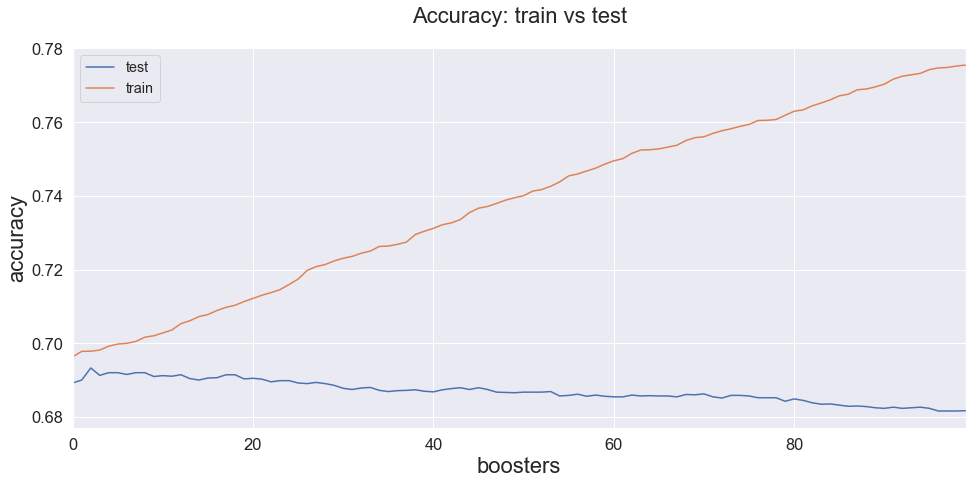

In [62]:
results_label.plot(figsize=(16,7))
plt.title('Accuracy: train vs test')
plt.ylabel('accuracy')
plt.xlabel('boosters');

In [42]:
display_dataframe(train.head())

id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,nom_0_enc,nom_1_enc,nom_2_enc,nom_3_enc,nom_4_enc,nom_5_enc,nom_6_enc,nom_7_enc,nom_8_enc,nom_9_enc
25772,0,0,0,T,N,Red,Triangle,Cat,Costa Rica,Bassoon,586b51342,a19d81efe,880957c19,d69adef8b,7fe5ee983,1,Grandmaster,Cold,i,Q,ps,2,2,1,0,0,0,0,0,0,0,0,0,0
45791,1,0,0,T,Y,Red,Square,Snake,Finland,Bassoon,19db35594,6ea52a806,4a0ff1117,178ac6030,35a9ee7ef,1,Grandmaster,Hot,l,R,uy,7,3,0,0,1,1,1,0,1,1,1,1,1
25396,0,0,1,F,N,Red,Trapezoid,Lion,China,Theremin,0b3bec656,e866d44ea,b8240e94d,fe593b910,6fda251fa,1,Novice,Lava Hot,c,B,XI,7,1,0,0,2,2,2,1,2,2,2,2,2
43835,0,1,0,F,Y,Blue,Square,Lion,Finland,Oboe,af088d192,55a24a71b,f1aec6b64,802d6605a,7747eac5f,1,Grandmaster,Lava Hot,j,Q,sY,1,11,0,1,1,2,1,2,3,3,3,3,3
15782,0,0,1,F,N,Green,Star,Cat,Russia,Piano,c0534106d,12d88c9c3,f16ff4894,66c666931,64f44d6dd,2,Contributor,Freezing,g,Z,kr,3,11,0,2,3,0,3,3,4,4,4,4,4


#### Mean encoding or target encoding

In [43]:
def mean_encode(feature_name, train, test):
    mapping = train.groupby(feature_name)[target].mean()
    train[f'{feature_name}_enc'] = train[feature_name].map(mapping)
    test[f'{feature_name}_enc'] = test[feature_name].map(mapping)

In [44]:
mean_encode(feature_name, train, test)

In [45]:
display_dataframe(train.head())

id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,nom_0_enc,nom_1_enc,nom_2_enc,nom_3_enc,nom_4_enc,nom_5_enc,nom_6_enc,nom_7_enc,nom_8_enc,nom_9_enc
25772,0,0,0,T,N,Red,Triangle,Cat,Costa Rica,Bassoon,586b51342,a19d81efe,880957c19,d69adef8b,7fe5ee983,1,Grandmaster,Cold,i,Q,ps,2,2,1,0,0,0.34,0,0,0,0,0,0,0
45791,1,0,0,T,Y,Red,Square,Snake,Finland,Bassoon,19db35594,6ea52a806,4a0ff1117,178ac6030,35a9ee7ef,1,Grandmaster,Hot,l,R,uy,7,3,0,0,1,0.31,1,0,1,1,1,1,1
25396,0,0,1,F,N,Red,Trapezoid,Lion,China,Theremin,0b3bec656,e866d44ea,b8240e94d,fe593b910,6fda251fa,1,Novice,Lava Hot,c,B,XI,7,1,0,0,2,0.29,2,1,2,2,2,2,2
43835,0,1,0,F,Y,Blue,Square,Lion,Finland,Oboe,af088d192,55a24a71b,f1aec6b64,802d6605a,7747eac5f,1,Grandmaster,Lava Hot,j,Q,sY,1,11,0,1,1,0.29,1,2,3,3,3,3,3
15782,0,0,1,F,N,Green,Star,Cat,Russia,Piano,c0534106d,12d88c9c3,f16ff4894,66c666931,64f44d6dd,2,Contributor,Freezing,g,Z,kr,3,11,0,2,3,0.34,3,3,4,4,4,4,4


In [46]:
small = train[[feature_name, f'{feature_name}_enc', target]].sample(10).copy()
mean_encode(feature_name, small, test.iloc[:1].copy())
display_dataframe(small.sort_values(feature_name))

nom_2,nom_2_enc,target
Axolotl,0,0
Cat,0.33,0
Cat,0.33,1
Cat,0.33,0
Dog,0,0
Hamster,1,1
Lion,0,0
Snake,0,0
Snake,0,0
Snake,0,0


In [47]:
display_dataframe(train[[feature_name, f'{feature_name}_enc', target]].sample(10))

nom_2,nom_2_enc,target
Axolotl,0.32,1
Hamster,0.37,0
Cat,0.34,0
Hamster,0.37,0
Axolotl,0.32,1
Axolotl,0.32,0
Cat,0.34,1
Cat,0.34,0
Cat,0.34,0
Lion,0.29,0


In [48]:
encoded_cats = train.groupby(feature_name)[f'{feature_name}_enc'].first().to_dict()
encoded_cats = {v:f'{k}_{v:.3f}' for k,v in encoded_cats.items()}

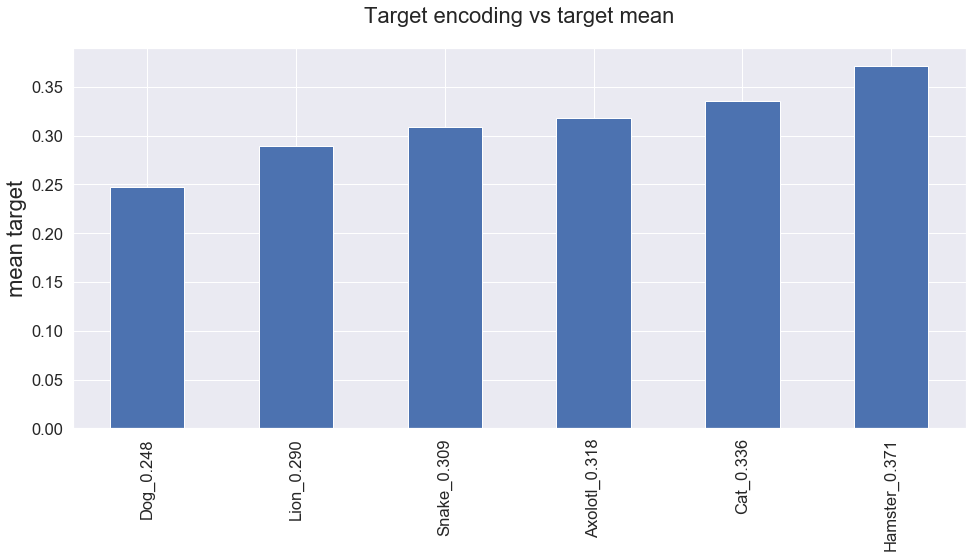

In [49]:
grp = train.groupby(f'{feature_name}_enc')[target].mean()
grp.index = [encoded_cats[idx] for idx in grp.index]
grp.plot(kind='bar', figsize=(16, 7))
plt.ylabel('mean target')
plt.title('Target encoding vs target mean');

In [52]:
for feature in categorical:
    mean_encode(feature, train, test)

results = train_xgb_model(train, test)
last_score = results['test'].iloc[-1]
print (f'Accuracy of final iteration: {last_score:.2f}')

Accuracy of final iteration: 0.63


In [54]:
results['test']

0     0.62680
1     0.63104
2     0.62704
3     0.63048
4     0.63216
       ...   
95    0.63248
96    0.63328
97    0.63384
98    0.63336
99    0.63384
Name: test, Length: 100, dtype: float64

In [53]:
display_dataframe(train.head())

id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,nom_0_enc,nom_1_enc,nom_2_enc,nom_3_enc,nom_4_enc,nom_5_enc,nom_6_enc,nom_7_enc,nom_8_enc,nom_9_enc
25772,0,0,0,T,N,Red,Triangle,Cat,Costa Rica,Bassoon,586b51342,a19d81efe,880957c19,d69adef8b,7fe5ee983,1,Grandmaster,Cold,i,Q,ps,2,2,1,0.35,0.37,0.34,0.32,0.24,0.37,0.33,0.33,0.25,0.38
45791,1,0,0,T,Y,Red,Square,Snake,Finland,Bassoon,19db35594,6ea52a806,4a0ff1117,178ac6030,35a9ee7ef,1,Grandmaster,Hot,l,R,uy,7,3,0,0.35,0.33,0.31,0.25,0.24,0.32,0.32,0.3,0.32,0
25396,0,0,1,F,N,Red,Trapezoid,Lion,China,Theremin,0b3bec656,e866d44ea,b8240e94d,fe593b910,6fda251fa,1,Novice,Lava Hot,c,B,XI,7,1,0,0.35,0.29,0.29,0.31,0.35,0.41,0.35,0.12,0.22,0.29
43835,0,1,0,F,Y,Blue,Square,Lion,Finland,Oboe,af088d192,55a24a71b,f1aec6b64,802d6605a,7747eac5f,1,Grandmaster,Lava Hot,j,Q,sY,1,11,0,0.24,0.33,0.29,0.25,0.33,0.4,0.34,0.2,0.75,0
15782,0,0,1,F,N,Green,Star,Cat,Russia,Piano,c0534106d,12d88c9c3,f16ff4894,66c666931,64f44d6dd,2,Contributor,Freezing,g,Z,kr,3,11,0,0.33,0.32,0.34,0.29,0.3,0.25,0.17,0.22,0.32,0


####  What is going on?

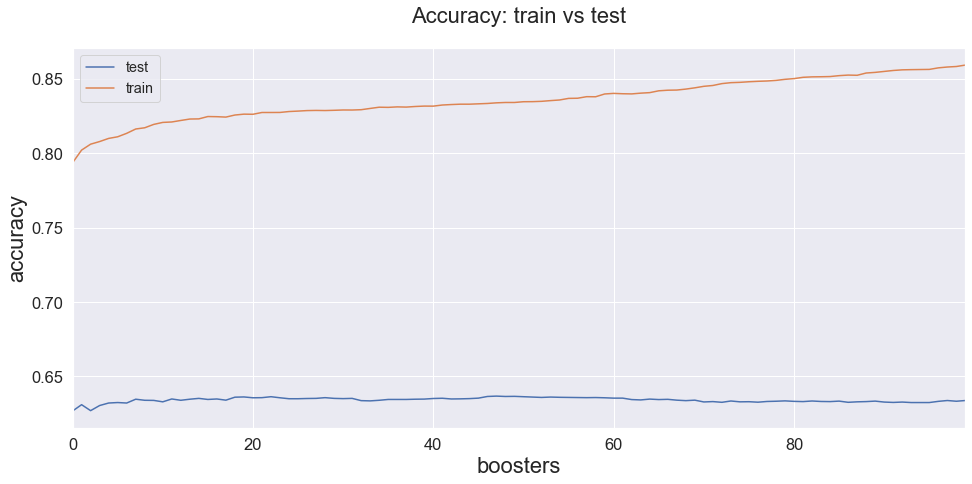

In [27]:
results.plot(figsize=(16,7))
plt.title('Accuracy: train vs test')
plt.ylabel('accuracy')
plt.xlabel('boosters');

#### How does the leak happen?

In [71]:
df = pd.DataFrame({'feature': [0,1,2,3,4],
                   'target': np.random.randint(0,2, 5)})
display_dataframe(df)

feature,target
0,0
1,1
2,1
3,1
4,1


In [72]:
df['feature_enc'] = df['feature'].map(df.groupby('feature')['target'].mean())
display_dataframe(df)

feature,target,feature_enc
0,0,0
1,1,1
2,1,1
3,1,1
4,1,1


### 3. Regularization of mean encodings

Simple technique to avoid data leakage, whenever there is enough data, to use an initial portion of the data to learn encodings and train on the rest.

In [73]:
def mean_encode_reg(feature_name, train, test):
    global_mean = train[target].mean()
    kfold = StratifiedKFold(n_splits=5, random_state=1)

    for idx_tr, idx_tst in kfold.split(train, train[target]):
        tr = train.iloc[idx_tr]
        mask = np.zeros(len(train), dtype=bool)
        mask[idx_tst] = True
        mapping = tr.groupby(feature_name)[target].mean()
        train.loc[mask, f'{feature_name}_enc'] = train.loc[mask, feature_name].map(mapping)
    
    train[f'{feature_name}_enc'].fillna(train[f'{feature_name}_enc'].mean(), inplace=True)
    
    
    mapping = train.groupby(feature_name)[target].mean()
    test[f'{feature_name}_enc'] = test[feature_name].map(mapping).fillna(global_mean)

In [74]:
for feature in categorical:
    mean_encode_reg(feature, train, test)

results_reg = train_xgb_model(train, test)
last_score = results_reg['test'].iloc[-1]
print (f'Accuracy of final iteration: {last_score:.2f}')

Accuracy of final iteration: 0.68


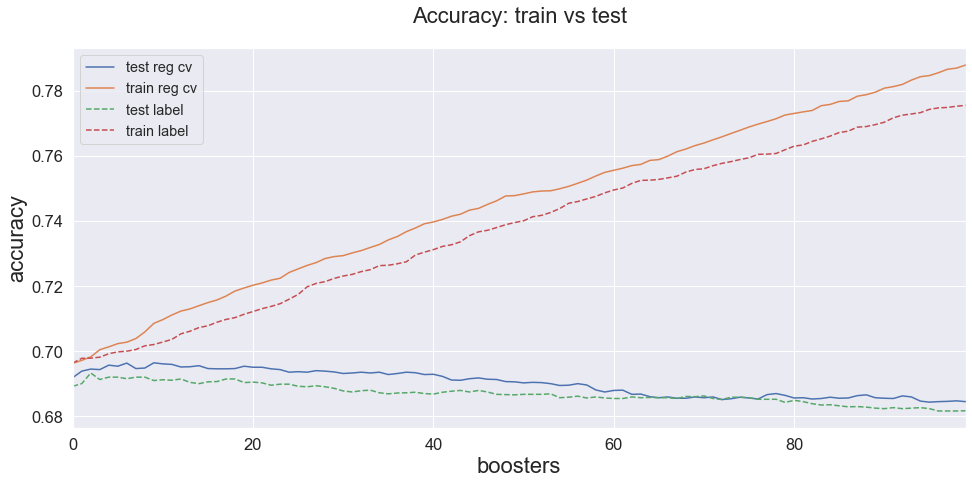

In [75]:
results_reg['test'].plot(figsize=(16,7), label='test reg cv')
results_reg['train'].plot(figsize=(16,7), label='train reg cv')

results_label['test'].plot(figsize=(16,7), label='test label', style='--')
results_label['train'].plot(figsize=(16,7), label='train label', style='--')
plt.title('Accuracy: train vs test')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('boosters');

### 4. Extensions of mean encodings

1. We can use it with regression problems too!
1. We can use other statistics apart from mean, for example median, mode, standard deviation for those.
1. Catboost uses a different regularization technique called "ordered target encoding" where statsitcs are calculated from the running mean from several permutations. The running mean is set to be the next value.
1. Multiclass classification, has advantage of bringing information from all classes to one-vs-all style classification.
1. Another place to try this is when we have many to many relationship between features. One example is products and shopping baskets where we can have many products in one shopping basket and we can also have many shopping baskets containing the same product. More details can be found in [this video](https://www.youtube.com/watch?v=ydMc6q98How&list=PLpQWTe-45nxL3bhyAJMEs90KF_gZmuqtm&index=39).

#### Conclusions about mean encodings
* Regularization could be hard and there are many ways to create dataleaks and overfit.
* It doesn't work with all datasets.
* But when it works well it can bring a significant improvement!

#### Mean Encodings References

 * Why you should try mean encodings: [link](https://towardsdatascience.com/why-you-should-try-mean-encoding-17057262cd0).
 * Good introduction on Coursera: How to Win a Data Science Competition video: [video 37](https://www.youtube.com/watch?v=AV_hJN1ALnI&list=PLpQWTe-45nxL3bhyAJMEs90KF_gZmuqtm&index=37).
 * Another useful [blogpost](https://towardsdatascience.com/getting-deeper-into-categorical-encodings-for-machine-learning-2312acd347c8).
 * CatBoost documentation explaining ordered target encoding [link](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html)
 * **category_encoders**: Library implementing various encodings compatible with sklearn: [link](https://contrib.scikit-learn.org/categorical-encoding/)

### 5. Group statistics

In [77]:
data = pd.read_csv('titanic/train.csv')
display_dataframe(data.head())

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2,nan,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9,nan,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.1,nan,S


In [78]:
def group_statistic( grouped_variable, value_variable, aggregation_method):
    mapping = data.groupby(grouped_variable)[value_variable].agg(aggregation_method)
    return data[grouped_variable].map(mapping)

In [79]:
data['max_age'] = group_statistic('Pclass', 'Age', np.max)
data['min_age'] = group_statistic('Pclass', 'Age', np.min)
data['median_age'] = group_statistic('Pclass', 'Age', np.median)

In [80]:
data['max_fare'] = group_statistic('Pclass', 'Fare', np.max)
data['min_fare'] = group_statistic('Pclass', 'Fare', np.min)
data['median_fare'] = group_statistic('Pclass', 'Fare', np.median)

In [81]:
data['max_fare_emb'] = group_statistic('Embarked', 'Fare', np.max)
data['min_fare_emb'] = group_statistic('Embarked', 'Fare', np.min)
data['median_fare_emb'] = group_statistic('Embarked', 'Fare', np.median)

In [82]:
display_dataframe(data[['Pclass', 'max_age', 'median_age', 'max_fare', 'min_fare']].head())

Pclass,max_age,median_age,max_fare,min_fare
3,74,24,70,0
1,80,37,5.1e+02,0
3,74,24,70,0
1,80,37,5.1e+02,0
3,74,24,70,0


The same techniques apply really well with time series data and a rolling window.

### 6. Group statistics with nearest neigbours

This is a very flexible technique to create groups whenever they might not naturally occur. 

Apart from sklearn's implementation for nearest neighbour search check out:

 * **FLANN** - Fast Library for Approximate Nearest Neighbors

 * **ANNOY** - Approximate Nearest Neighbors Oh Yeah
 
These two are really fast but target lowish dimensionality < 1000.

 * **pysparnn** - Approximate Nearest Neighbor Search for Sparse Data in Python

This one can handle sparse inputs, for example out of Tf-Idf or HashingVectorizer transformation. It is still extremelly fast in higher dimensional spaces.

In [83]:
tfidf = TfidfVectorizer()
data['name_clean'] = data['Name'].str.replace('\W', ' ').str.lower()
name_vectorized = tfidf.fit_transform(data.name_clean).toarray()

k_tree = NearestNeighbors(metric='cosine', n_neighbors=3,).fit(name_vectorized)
distance, idx = k_tree.kneighbors(name_vectorized)
distance, idx = distance[:, 1:], idx[:, 1:]

In [84]:
i = 2
distance[i, :], idx[i, :]

(array([0.91609047, 0.92054691]), array([128, 264]))

In [85]:
data.iloc[i].name_clean, data.iloc[idx[i, 0]].name_clean, data.iloc[idx[i, 1]].name_clean 

('heikkinen  miss  laina', 'peter  miss  anna', 'henry  miss  delia')

In [86]:
data['n0_survived'] = data.iloc[idx[:,0]]['Survived'].values
data['n0_class'] = data.iloc[idx[:,0]]['Pclass'].values
data['n0_fare'] = data.iloc[idx[:,0]]['Fare'].values
data['n0_sex'] = data.iloc[idx[:,0]]['Sex'].values
data['n0_age'] = data.iloc[idx[:,0]]['Age'].values
data['n0_dist'] = distance[:, 0]

data['n1_survived'] = data.iloc[idx[:,1]]['Survived'].values
data['n1_class'] = data.iloc[idx[:,1]]['Pclass'].values
data['n1_fare'] = data.iloc[idx[:,1]]['Fare'].values
data['n1_sex'] = data.iloc[idx[:,1]]['Sex'].values
data['n1_age'] = data.iloc[idx[:,1]]['Age'].values
data['n1_dist'] = distance[:, 1]

data['n0_n1_survived'] =  (data.iloc[idx[:,0]]['Survived'].values & 
                           data.iloc[idx[:,1]]['Survived'].values)
data['n0_n1_mean_fare'] = (data.iloc[idx[:,0]]['Fare'].values + 
                           data.iloc[idx[:,1]]['Fare'].values) / 2.

### 7. Feature interactions and feature selection

In [87]:
display_dataframe(data[['Embarked', 'Pclass']].head())

Embarked,Pclass
S,3
C,1
S,3
S,1
S,3


In [88]:
data['embarked_class'] = (data['Pclass'].astype(str) + data['Embarked'])

In [89]:
display_dataframe(data[['Embarked', 'Pclass', 'embarked_class']].head())

Embarked,Pclass,embarked_class
S,3,3S
C,1,1C
S,3,3S
S,1,1S
S,3,3S


In [90]:
data['sex_class'] = data['Sex'] + data['Pclass'].astype(str)
data['age_buckets'] = pd.cut(data['Age'], 5) # pd.cut creates evenly spaced buckets
data['age_sex_class'] = data['sex_class'] + data['age_buckets'].astype(str)

In [91]:
display_dataframe(data['embarked_class'].value_counts().reset_index().rename({'index':'embarked_class',
                                                                              'embarked_class': 'count'}, axis=1))

embarked_class,count
3S,353
2S,164
1S,127
1C,85
3Q,72
3C,66
2C,17
2Q,3
1Q,2


In [92]:
display_dataframe(data['age_sex_class'].value_counts().reset_index().rename({'index':'age_sex_class',
                                                           'age_sex_class': 'count'}, axis=1).head(10))

age_sex_class,count
"male3(16.336, 32.252]",151
male3nan,94
"male3(32.252, 48.168]",54
"female3(16.336, 32.252]",52
"male2(16.336, 32.252]",48
female3nan,42
"male1(32.252, 48.168]",39
"male3(0.34, 16.336]",37
"female2(16.336, 32.252]",36
"female3(0.34, 16.336]",33


**Don't forget we can mean encode categorical feature interactions too!!**

#### Find important features
I like using LightGBM for this as it sets the importance of useless features to 0.

In [93]:
features = ['max_age', 'min_age', 'median_age', 'max_fare', 'min_fare',
            'median_fare', 'max_fare_emb', 'min_fare_emb', 'median_fare_emb',
            'n0_survived', 'n0_class', 'n0_fare', 'n0_sex', 'n0_age',
           'n0_dist', 'n1_survived', 'n1_class', 'n1_fare', 'n1_sex', 'n1_age',
           'n1_dist', 'embarked_class', 'sex_class', 'age_buckets',
           'age_sex_class', 'Pclass', 'Sex', 'Fare', 'Age']

In [94]:
categorical = list(data[features].select_dtypes(include=object).columns)

for feature in categorical + ['age_buckets']:
    vals = data[feature].unique()
    mapping = {v: i for i, v in enumerate(vals)}
    data[feature] = data[feature].apply(lambda v : mapping.get(v, -1))

data['age_buckets'] = data['age_buckets'].astype(float)

clf = LGBMClassifier().fit(data[features], data['Survived'])

In [95]:
display_dataframe(pd.DataFrame({'importance': clf.feature_importances_},
             index=features).sort_values('importance', ascending=False).\
                  reset_index().rename({'index': 'feature name'}, axis=1))

feature name,importance
Fare,455
Age,453
n0_dist,307
n0_age,290
n1_age,281
n1_dist,250
n1_fare,208
n0_fare,169
age_sex_class,130
embarked_class,72


### 8. Sparse feature selection

There are several lossy techniques as RandomProjections, SVD, PCA etc. The approach proposed here applies well to sparse features with very high dimensionality where a lot of the features are likely to be redundant.

In [96]:
clf = LGBMClassifier().fit(name_vectorized, data['Survived'])

In [97]:
prop_important_features =(clf.feature_importances_ > 0).mean()
print (f'Only {prop_important_features*100:.2f}% of features have non zero importance')

Only 0.73% of features have non zero importance


In [98]:
vocabulary = {v:k for k,v in tfidf.vocabulary_.items()}

In [99]:
vocabulary_importance = pd.Series(clf.feature_importances_, 
                      index =[vocabulary[i] for i in range(len(vocabulary))])

In [100]:
vi = vocabulary_importance[vocabulary_importance > 0]
display_dataframe(pd.DataFrame({'words': vi.index, 'importance': vi.values}))

words,importance
charles,7
george,10
henry,57
james,19
john,84
master,100
miss,608
mr,1422
mrs,406
thomas,2
